## Logistic regression  in Theano

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import theano
import theano.tensor as T

### 'hello world' in Theano

In [2]:
# x is input placeholder
x = T.dmatrix('x')
# symbolic expression for logistic function
s = 1 / (1 + T.exp(-x))
# register s as a function of x
logistic = theano.function([x], s)

logistic([[0, 1], [-1, -2]])

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

### The model itself

The model uses regularization with $l_1$ and $l_2$ penalty, and is trained with gradient descent.

In [79]:
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score 


class LogisticRegression:
    
  
  def __init__(self,
               n_iter,
               lmbda=0.0001,
               l1_ratio=0,
               learning_rate=0.001):
    self.n_iter = n_iter
    self.is_fitted = False
    self.l1_ratio = l1_ratio
    self.lmbda = lmbda
    self.learning_rate = learning_rate 
   
  
  def fit(self, X, y):
    n_dim = X.shape[1]
    n_classes = len(np.unique(y))
    
    # inputs
    self.thX = T.dmatrix('thX')
    self.thy = T.vector('thy', dtype='int64')
    
    # weights
    self.thW, self.thB = self.__initialized_weights(n_dim, n_classes)
    
    # calculate probability and loss 
    Z = T.dot(self.thX, self.thW) + self.thB
    self.p_y_by_x = T.nnet.softmax(Z)
    # negative log likelihood
    ll = (T.log(self.p_y_by_x)
          [T.arange(y_train.shape[0]), self.thy]) 
    nll = - T.mean(ll)
      
    regularization = self.__regularization(self.thW, self.lmbda, self.l1_ratio)
    
    self.loss = nll + regularization
    
    updates = self.__updates(
      self.loss,
      self.thW,
      self.thB,
      self.learning_rate)
   
    # setup training
    self.train_model = theano.function(
      inputs=[self.thX, self.thy],
      outputs=self.loss,
      updates=updates)
    
    self.__iter_training(self.train_model, X, y, self.n_iter)
 

  def predict(self, X):
    if self.is_fitted:
      return self.__prediction_function()(X)
    else:
      raise NotFittedError

      
  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(y, y_pred)
      
       
  def __initialized_weights(self, n_dim, n_classes):
    thW = theano.shared(
        value=np.zeros(
          (n_dim, n_classes),
          dtype=theano.config.floatX),
        name='thW',
        borrow=True)

    # initialize the biases b as a vector of n_out 0s
    thB = theano.shared(
      value=np.zeros(
        (n_classes,),
        dtype=theano.config.floatX),
      name='thB',
      borrow=True)
    return thW, thB
       
    
  def __prediction_function(self):
    y_pred = T.argmax(self.p_y_by_x, axis=1)
    return theano.function(
      inputs=[self.thX],
      outputs=y_pred)
  
  
  def __regularization(self, W, lmbda, l1_ratio):
    weight_penalty = T.sum(W ** 2)
    l1_penalty = T.sum(abs(W))
    return  (lmbda * 
              ((1 - l1_ratio) * weight_penalty +
               l1_ratio * l1_penalty))
  
  
  def __updates(self, loss, W, B, learning_rate):
        # calculate gradients
    gW = T.grad(cost=loss, wrt=W)
    gB = T.grad(cost=loss, wrt=B)
      
    # basically gradient descent
    updates = [
      (W, W - learning_rate * gW),
      (B, B - learning_rate * gB)]
    return updates
  
  
  def __iter_training(self, train_model, X, y, n_iter):
    #results, updates = theano.scan(fn=self.train_model,
    #  outputs_info=[X, y],
    #  non_sequences=[self.thX, self.thy],
    #  n_steps=n_iter)
    
    self.losses = []
    for __ in range(n_iter):
      current_loss = train_model(X, y)
      self.losses.append(current_loss)
  
    self.is_fitted = True

## Training on MNIST dataset

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

digits = load_digits()
X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0) 


In [119]:
from sklearn.preprocessing import StandardScaler

sscaler = StandardScaler()
X_train = sscaler.fit_transform(X_train)
X_test = sscaler.transform(X_test)

In [150]:
lreg = LogisticRegression(
  n_iter=250,
  lmbda=0.001,
  l1_ratio=1,
  learning_rate=0.01)

CPU times: user 880 ms, sys: 8 ms, total: 888 ms
Wall time: 581 ms


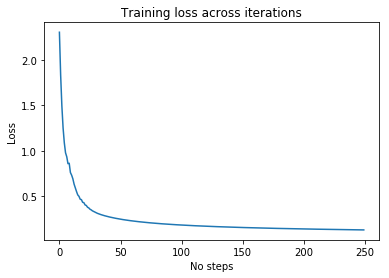

In [153]:
%time lreg.fit(X_train, y_train)

plt.plot(lreg.losses)
plt.title('Training loss across iterations')
plt.xlabel('No steps')
plt.ylabel('Loss')
plt.show()

In [154]:
from sklearn.metrics import classification_report, accuracy_score 

y_pred = lreg.predict(X_test)
print('accuracy: {:.4f}'.format(lreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

accuracy: 0.9704
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        54
          1       0.90      0.98      0.94        55
          2       1.00      0.98      0.99        53
          3       1.00      0.93      0.96        55
          4       1.00      0.96      0.98        54
          5       0.93      0.98      0.96        55
          6       1.00      0.98      0.99        54
          7       0.96      1.00      0.98        54
          8       0.92      0.90      0.91        52
          9       1.00      0.98      0.99        54

avg / total       0.97      0.97      0.97       540



## Visualizing weights

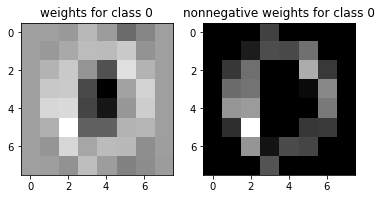

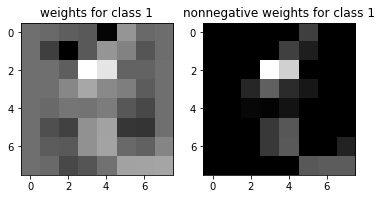

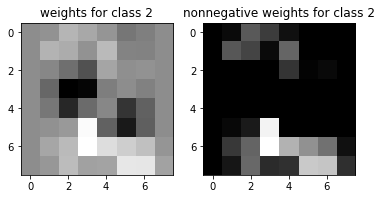

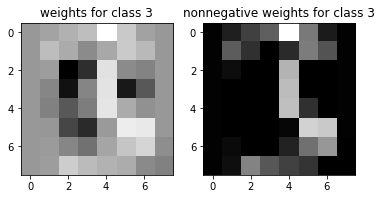

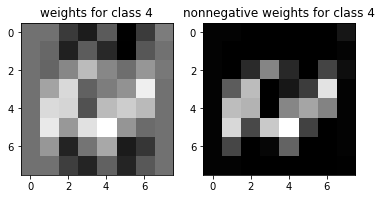

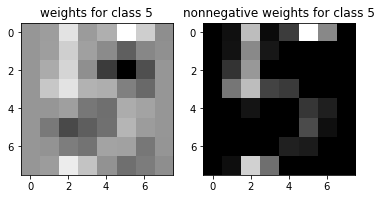

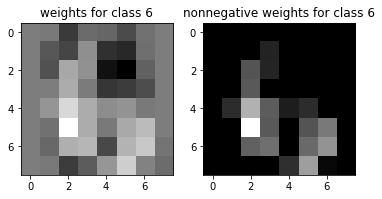

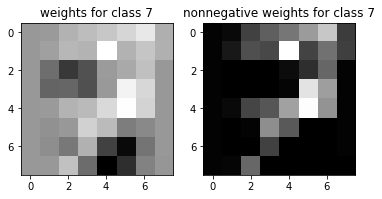

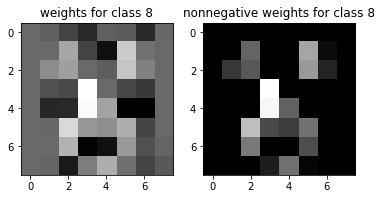

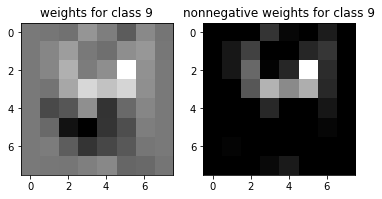

In [163]:
b = lreg.thB.get_value()

for i in range(10):
  digit_weights = lreg.thW.get_value().T[i, :].reshape(8, 8) + b[i]
  f, ((ax1, ax2)) = plt.subplots(1, 2)
  
  ax1.imshow(digit_weights , cmap='gray')
  ax1.set_title('weights for class {}'.format(str(i)))
  #ax1.show()
  
  ax2.imshow(digit_weights * (digit_weights > 0), cmap='gray')
  ax2.set_title('nonnegative weights for class {}'.format(str(i)))
  plt.show()